<a href="https://colab.research.google.com/github/hendra136/employeformance/blob/main/employeformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Path file Excel kamu
file_path = '/content/drive/MyDrive/Case_study_DA/Employee.xlsx'

# Membaca semua sheet sekaligus ke dalam dictionary
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Menampilkan nama semua sheet yang terbaca
print("Nama semua sheet di file ini:")
for sheet in all_sheets.keys():
    print("-", sheet)


Nama semua sheet di file ini:
- Talent Variable (TV) & Talent G
- dim_companies
- dim_areas
- dim_positions
- dim_departments
- dim_divisions
- dim_directorates
- dim_grades
- dim_education
- dim_majors
- dim_competency_pillars
- employees
- profiles_psych
- papi_scores
- strengths
- performance_yearly
- competencies_yearly


In [ ]:
print("--- Tahap 1.A: Memuat Semua DataFrame ---")
# 1. Load semua DataFrame yang kita butuhkan dari 'all_sheets'
df_emp = all_sheets['employees']
df_perf = all_sheets['performance_yearly']
df_psych = all_sheets['profiles_psych']
df_papi = all_sheets['papi_scores']
df_strengths = all_sheets['strengths']
df_comp = all_sheets['competencies_yearly']
df_dim_grades = all_sheets['dim_grades']
df_dim_pillars = all_sheets['dim_competency_pillars']
df_dim_pos = all_sheets['dim_positions']
df_dim_dept = all_sheets['dim_departments']

print("✅ Berhasil memuat semua 10 DataFrame utama.")

--- Tahap 1.A: Memuat Semua DataFrame ---
✅ Berhasil memuat semua 10 DataFrame utama.


In [ ]:
# 2. Bersihkan Data Kinerja
df_perf['year'] = pd.to_numeric(df_perf['year'], errors='coerce')
df_perf['rating'] = pd.to_numeric(df_perf['rating'], errors='coerce')

# 3. BUAT FLAG PERFORMA

In [ ]:
# Cara 1: Berdasarkan Tahun Terbaru (2025)
df_perf_latest = df_perf[df_perf['year'] == 2025].copy()
df_perf_latest['status_latest_2025'] = np.where(df_perf_latest['rating'] == 5, 'Top Performer', 'Non-Performer')

In [ ]:
# Cara 2: Berdasarkan Kinerja Stabil (Rata-rata >= 4.0 DAN rating 2025 = 5)
df_perf_agg = df_perf.groupby('employee_id')['rating'].agg(
    avg_rating='mean',
    count_years='count'
).reset_index()

# Gabungkan data agregat dengan data 2025
df_perf_summary = df_perf_latest.merge(df_perf_agg, on='employee_id', how='left')

df_perf_summary['status_stabil'] = np.where(
    (df_perf_summary['rating'] == 5) & (df_perf_summary['avg_rating'] >= 4.0),
    'Top Performer (Stabil)',
    'Non-Performer'
)

print("\nDefinisi grup performa (stabil) dibuat:")
print(df_perf_summary['status_stabil'].value_counts())


Definisi grup performa (stabil) dibuat:
status_stabil
Non-Performer             1969
Top Performer (Stabil)      41
Name: count, dtype: int64


# 4. BUAT DataFrame MASTER untuk Analisis

In [ ]:
# Kita akan gunakan 'status_stabil' sebagai acuan utama
df_master = df_emp.merge(
    df_perf_summary[['employee_id', 'status_latest_2025', 'status_stabil', 'avg_rating']],
    on='employee_id',
    how='left'
)
# Hapus karyawan yang tidak punya data performa
df_master = df_master.dropna(subset=['status_stabil'])



TAMPILKAN KARYAWAN TOP PERFORMANCE (STABIL)

In [ ]:
print("\n\n--- Tahap 1.B: Daftar Karyawan Top Performer (Stabil) ---")

# Gabungkan dengan dimensi posisi dan departemen untuk data yang lebih kaya
df_top_performers = df_master[df_master['status_stabil'] == 'Top Performer (Stabil)']
df_top_performers = df_top_performers.merge(df_dim_pos, on='position_id', how='left', suffixes=('_emp', '_pos'))
df_top_performers = df_top_performers.merge(df_dim_dept, on='department_id', how='left', suffixes=('_pos', '_dept'))





--- Tahap 1.B: Daftar Karyawan Top Performer (Stabil) ---


In [ ]:
# Urutkan dari nilai tertinggi ke terendah berdasarkan rata-rata rating
df_sorted_top = df_top_performers.sort_values(by='avg_rating', ascending=False)

# Tampilkan kolom yang relevan
print(f"Total ada {len(df_top_performers)} karyawan Top Performer (Stabil).")
print(df_top_performers[['fullname', 'name_dept', 'avg_rating']].head(5))

Total ada 41 karyawan Top Performer (Stabil).
                   fullname  name_dept  avg_rating
0        Rendra Tri Purnama         IT    4.000000
1          Budi Adi Permadi         IT    4.333333
2  Sari Yudhistira Mahendra         HR    4.000000
3             Wulan Maulida  Marketing    4.400000
4       Satya Halim Hidayat         IT    4.000000


PERBANDINGAN TOP vs NON-PERFORMANCE (EDA)

**Visualisasi Grade**



--- 1.C.1: Analisis Kontekstual (Grade & Lama Kerja) ---


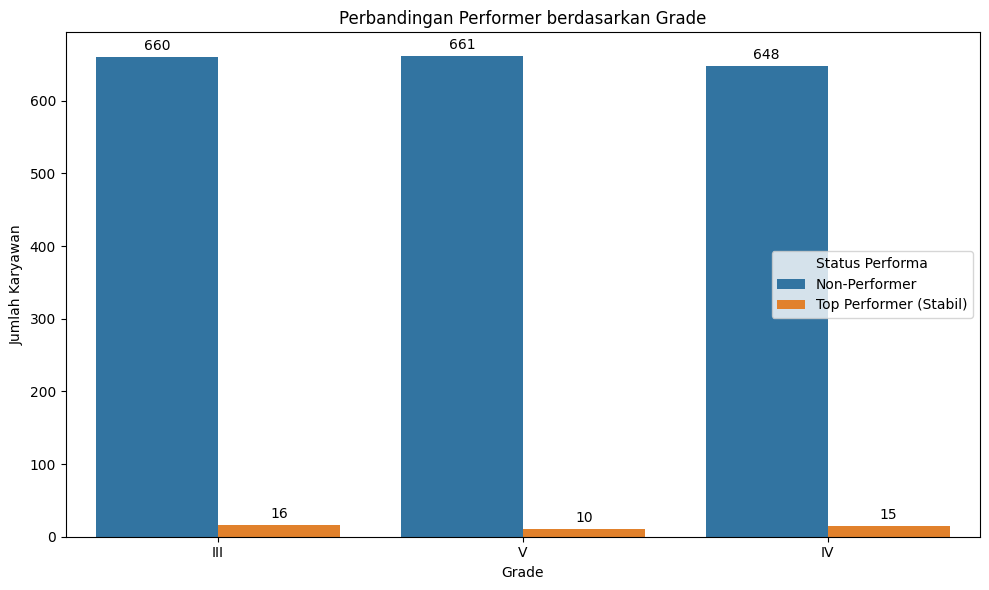

In [ ]:
#FAKTOR KONTEKSTUAL (Grade & Lama Kerja)
print("\n\n--- 1.C.1: Analisis Kontekstual (Grade & Lama Kerja) ---")

df_ctx = df_master.merge(df_dim_grades, on='grade_id', how='left')
df_ctx['years_of_service_months'] = pd.to_numeric(df_ctx['years_of_service_months'], errors='coerce')


# Visualisasi Grade
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_ctx, x='name', hue='status_stabil', order=df_ctx['name'].value_counts().index)
plt.title('Perbandingan Performer berdasarkan Grade')
plt.xlabel('Grade')
plt.legend(title='Status Performa')
# plt.show() # Hapus plt.show() pertama di sini


# Tambahkan label jumlah di atas tiap bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

plt.title('Perbandingan Performer berdasarkan Grade')
plt.xlabel('Grade')
plt.ylabel('Jumlah Karyawan')
plt.legend(title='Status Performa')
plt.tight_layout()
plt.show()

**Visualisasi Lama Kerja**

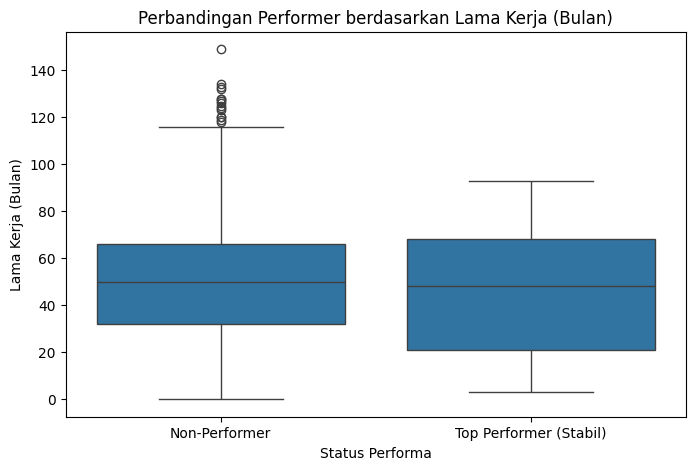

In [ ]:
# Visualisasi Lama Kerja
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_ctx, x='status_stabil', y='years_of_service_months')
plt.title('Perbandingan Performer berdasarkan Lama Kerja (Bulan)')
plt.xlabel('Status Performa')
plt.ylabel('Lama Kerja (Bulan)')
plt.show()

**FAKTOR PSIKOMETRI (IQ & PAPI)**


--- 1.C.2: Analisis Psikometri (IQ & PAPI) ---


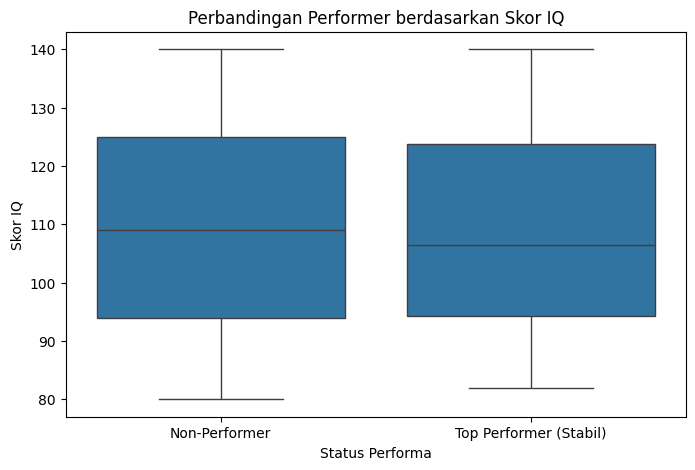

In [ ]:
# 2. FAKTOR PSIKOMETRI (IQ & PAPI)
print("\n--- 1.C.2: Analisis Psikometri (IQ & PAPI) ---")

# Analisis IQ
df_psych_comp = df_master.merge(df_psych, on='employee_id', how='left')
df_psych_comp['iq'] = pd.to_numeric(df_psych_comp['iq'], errors='coerce')

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_psych_comp, x='status_stabil', y='iq')
plt.title('Perbandingan Performer berdasarkan Skor IQ')
plt.xlabel('Status Performa')
plt.ylabel('Skor IQ')
plt.show()

**Analisis PAPI (Heatmap)**


Rata-rata Skor PAPI (Top Performer vs Non-Performer):
status_stabil  Non-Performer  Top Performer (Stabil)
scale_code                                          
Papi_A              5.051183                4.076923
Papi_B              4.904762                5.525000
Papi_C              4.865027                4.628571
Papi_D              4.972345                5.225000
Papi_E              5.065681                5.076923
Papi_F              5.055061                5.153846
Papi_G              4.932269                4.897436
Papi_I              5.030973                5.297297
Papi_K              5.016174                5.000000
Papi_L              5.100167                5.083333
Papi_N              5.094111                5.027027
Papi_O              4.887205                5.153846
Papi_P              4.994574                5.102564
Papi_R              5.014294                5.560976
Papi_S              5.004417                4.500000
Papi_T              4.959139                

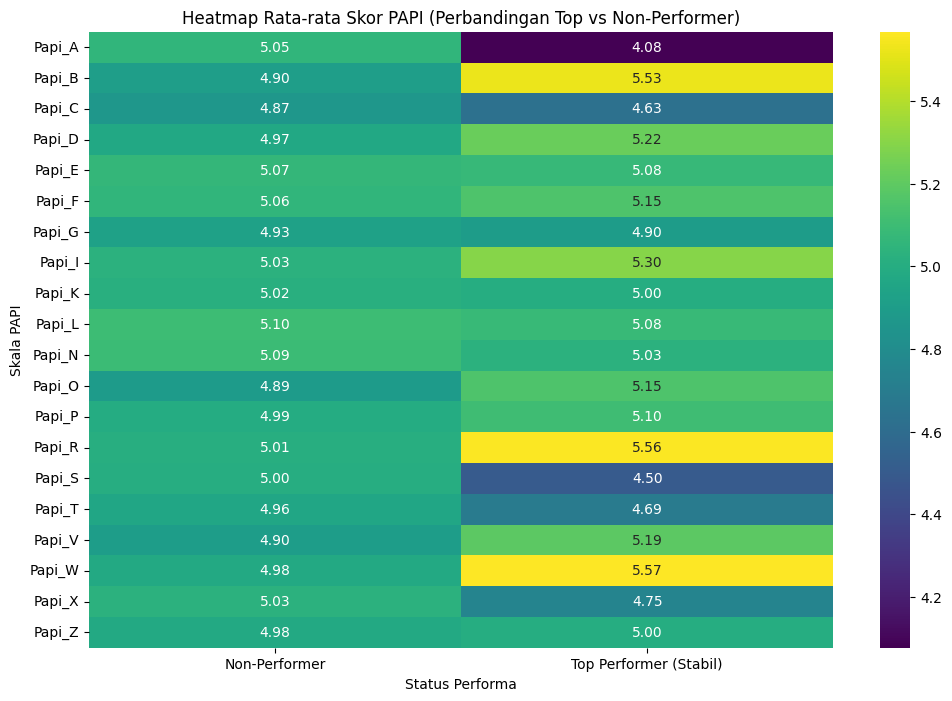

In [ ]:
# Analisis PAPI (Heatmap)
df_papi['score'] = pd.to_numeric(df_papi['score'], errors='coerce')
df_papi_comp = df_papi.merge(df_master[['employee_id', 'status_stabil']], on='employee_id', how='left')
df_papi_avg = df_papi_comp.groupby(['scale_code', 'status_stabil'])['score'].mean().unstack()

print("\nRata-rata Skor PAPI (Top Performer vs Non-Performer):")
print(df_papi_avg)

plt.figure(figsize=(12, 8))
sns.heatmap(df_papi_avg, annot=True, fmt=".2f", cmap="viridis")
plt.title('Heatmap Rata-rata Skor PAPI (Perbandingan Top vs Non-Performer)')
plt.xlabel('Status Performa')
plt.ylabel('Skala PAPI')
plt.show()

FAKTOR KOMPETENSI (Pillars)

In [ ]:
#FAKTOR KOMPETENSI (Pillars)
print("\n--- 1.C.3: Analisis Pilar Kompetensi ---")

# Ambil data kompetensi TAHUN TERBARU (2025)
df_comp['year'] = pd.to_numeric(df_comp['year'], errors='coerce')
df_comp['score'] = pd.to_numeric(df_comp['score'], errors='coerce')
df_comp_latest = df_comp[df_comp['year'] == 2025]

# Gabungkan dengan status performa stabil
df_comp_perf = df_comp_latest.merge(df_master[['employee_id', 'status_stabil']], on='employee_id', how='left')
df_comp_perf = df_comp_perf.merge(df_dim_pillars, on='pillar_code', how='left')

# Hitung rata-rata skor per pilar
df_comp_avg = df_comp_perf.groupby(['pillar_label', 'status_stabil'])['score'].mean().unstack()

print("\nRata-rata Skor Kompetensi 2025 (Top Performer vs Non-Performer):")
print(df_comp_avg)


--- 1.C.3: Analisis Pilar Kompetensi ---

Rata-rata Skor Kompetensi 2025 (Top Performer vs Non-Performer):
status_stabil                 Non-Performer  Top Performer (Stabil)
pillar_label                                                       
Commercial Savvy & Impact          3.369795                4.305556
Curiosity & Experimentation        3.070407                4.263158
Forward Thinking & Clarity         3.263302                4.361111
Growth Drive & Resilience          3.223381                4.378378
Insight & Decision Sharpness       3.234873                4.324324
Lead, Inspire & Empower            3.279558                4.222222
Quality Delivery Discipline        3.267887                4.475000
Social Empathy & Awareness         3.094846                4.540541
Synergy & Team Orientation         3.298441                4.300000
Value Creation for Users           3.326870                4.342105


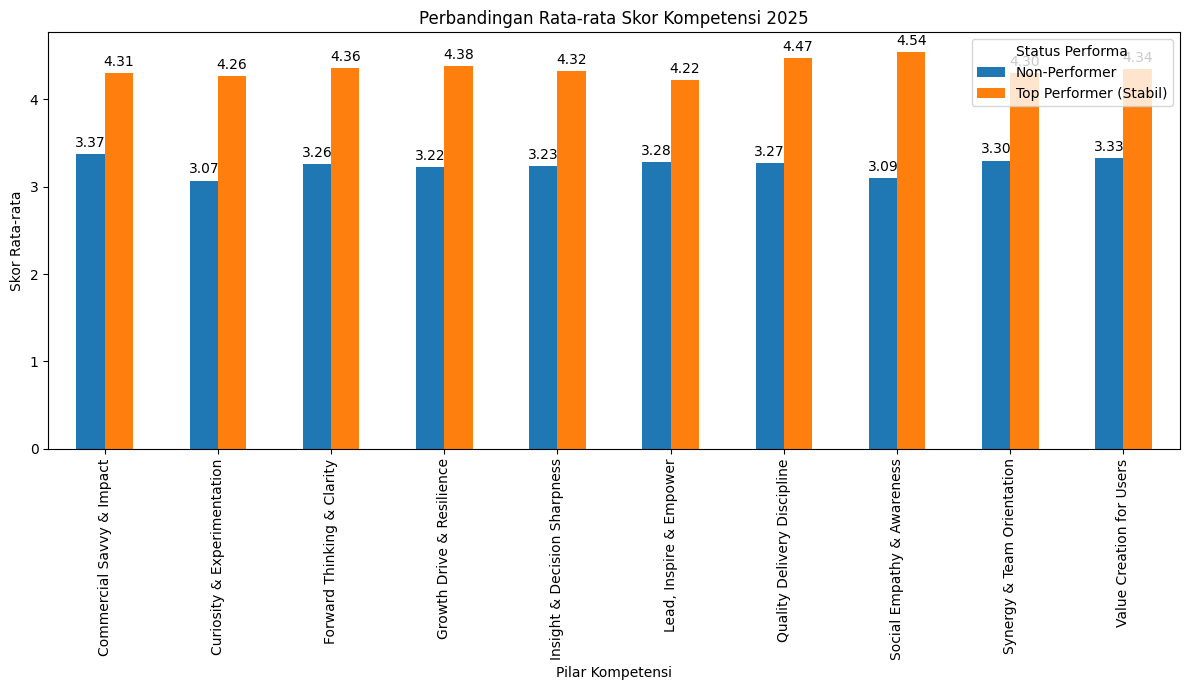

In [ ]:
# Visualisasi Skor Kompetensi
ax = df_comp_avg.plot(kind='bar', figsize=(12, 7))
plt.title('Perbandingan Rata-rata Skor Kompetensi 2025')
plt.ylabel('Skor Rata-rata')
plt.xlabel('Pilar Kompetensi')
plt.legend(title='Status Performa')

# Tambahkan label angka pada bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, padding=3)


plt.tight_layout()
plt.show()

FAKTOR PERILAKU (Strengths)

In [ ]:
# FAKTOR PERILAKU (Strengths)
print("\n--- 1.C.4: Analisis Perilaku (Strengths) ---")

df_strengths['rank'] = pd.to_numeric(df_strengths['rank'], errors='coerce')
df_strengths_comp = df_strengths.merge(df_master[['employee_id', 'status_stabil']], on='employee_id', how='left')

# Filter HANYA Top Performer Stabil & Top 5 Strengths
df_top_strengths = df_strengths_comp[
    (df_strengths_comp['status_stabil'] == 'Top Performer (Stabil)') &
    (df_strengths_comp['rank'] <= 5)
]

# Hitung frekuensi
top_themes = df_top_strengths['theme'].value_counts()

print(f"\nTop 10 Strengths Paling Umum di Kalangan {len(df_top_performers)} Top Performer:")
print(top_themes.head(10))


--- 1.C.4: Analisis Perilaku (Strengths) ---

Top 10 Strengths Paling Umum di Kalangan 41 Top Performer:
theme
Futuristic        11
Empathy           10
Discipline         9
Activator          9
Communication      9
Belief             8
Responsibility     8
Learner            8
Self-Assurance     7
Developer          7
Name: count, dtype: int64


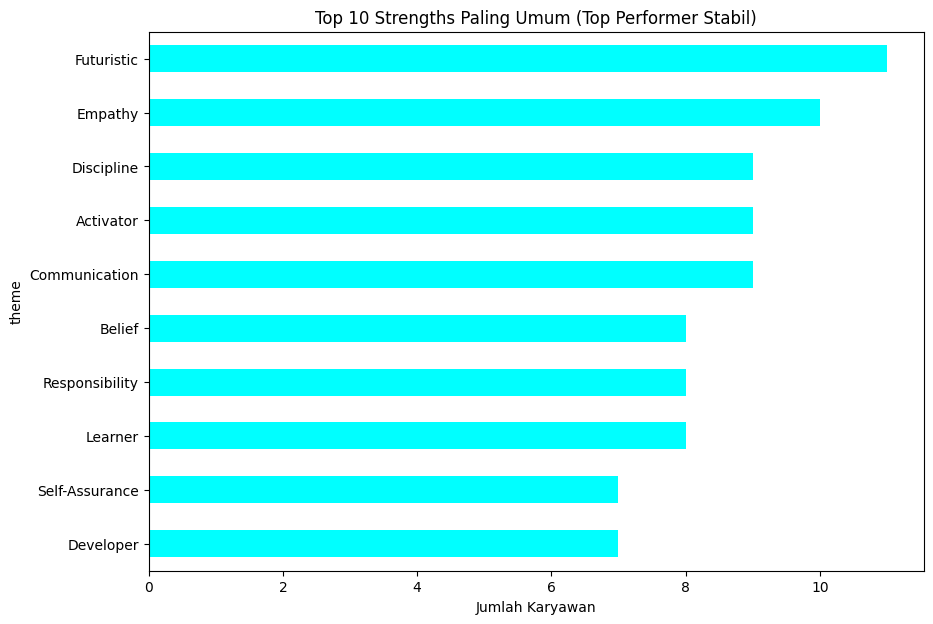

In [ ]:
# Visualisasi Top 10 Strengths
plt.figure(figsize=(10, 7))
top_themes.head(10).plot(kind='barh', color='cyan')
plt.title('Top 10 Strengths Paling Umum (Top Performer Stabil)')
plt.xlabel('Jumlah Karyawan')
plt.gca().invert_yaxis()
plt.show()